Test Accuracy: 58.80%
Classification Report:
               precision    recall  f1-score   support

          62       0.59      0.52      0.55        52
          63       0.67      0.62      0.65        50
          64       0.67      0.64      0.66        45
          65       0.63      0.44      0.52        43
          66       0.78      0.60      0.67        47
          67       0.25      0.69      0.37        59
          68       0.72      0.58      0.64        50
          69       0.78      0.54      0.64        52
          70       0.71      0.82      0.76        45
          73       0.33      0.61      0.43        49
          74       0.97      0.80      0.88        44
          75       0.55      0.61      0.58        54
          76       0.57      0.67      0.62        55
         100       0.93      0.46      0.62        56
        1657       0.85      0.38      0.53        60
        1837       0.45      0.66      0.54        44
        1859       0.85      0.67  

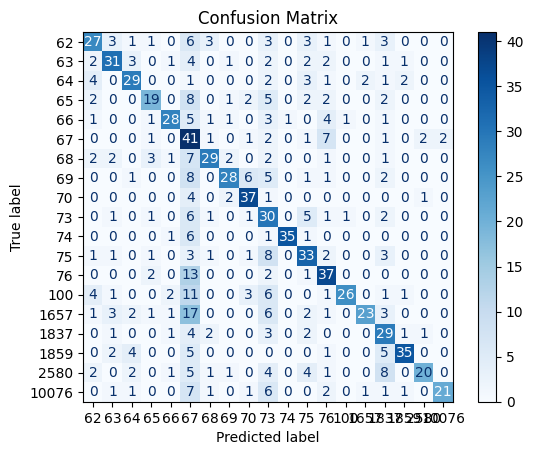

In [7]:
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. 載入資料
def load_data(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

# 2. 資料預處理
def preprocess_data(data):
    text_data = []
    labels = []
    for item in data:
        # 合併文字特徵 (name 和 description)
        name_text = " ".join(item['name_wseg_list'][0])
        description_text = " ".join([" ".join(desc) for desc in item['description_wseg_list']])
        combined_text = f"{name_text} {description_text}"

        text_data.append(combined_text)
        labels.append(item['catid'])  # 假設分類標籤是 catid，可根據需求更改

    return text_data, labels

# 3. 向量化文字特徵 (TF-IDF)
def vectorize_text(train_texts, test_texts):
    vectorizer = TfidfVectorizer(max_features=1000)  # 設定最多保留 1000 個特徵
    train_vectors = vectorizer.fit_transform(train_texts).toarray()
    test_vectors = vectorizer.transform(test_texts).toarray()
    return train_vectors, test_vectors

# 載入訓練與測試資料
train_data = load_data('train_data.json')
test_data = load_data('test_data.json')

# 預處理資料
train_texts, train_labels = preprocess_data(train_data)
test_texts, test_labels = preprocess_data(test_data)

# 向量化文字資料
train_features, test_features = vectorize_text(train_texts, test_texts)

# 標準化數據 (KNN 對距離敏感)
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

# 4. 建立 KNN 模型
k = 7  # 設定鄰居數
knn = KNeighborsClassifier(n_neighbors=k)

# 訓練模型
knn.fit(train_features, train_labels)

# 測試模型
predicted_labels = knn.predict(test_features)

# 5. 評估模型
accuracy = accuracy_score(test_labels, predicted_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:\n", classification_report(test_labels, predicted_labels))


conf_matrix = confusion_matrix(test_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=knn.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()

Test Accuracy: 79.98%
Classification Report:
               precision    recall  f1-score   support

          62       0.80      0.69      0.74        52
          63       0.86      0.84      0.85        50
          64       0.85      0.89      0.87        45
          65       0.83      0.81      0.82        43
          66       0.84      0.79      0.81        47
          67       0.75      0.68      0.71        59
          68       0.70      0.70      0.70        50
          69       0.93      0.75      0.83        52
          70       0.96      0.96      0.96        45
          73       0.56      0.78      0.65        49
          74       1.00      0.89      0.94        44
          75       0.73      0.81      0.77        54
          76       0.81      0.80      0.81        55
         100       0.78      0.89      0.83        56
        1657       0.92      0.80      0.86        60
        1837       0.76      0.80      0.78        44
        1859       0.88      0.88  

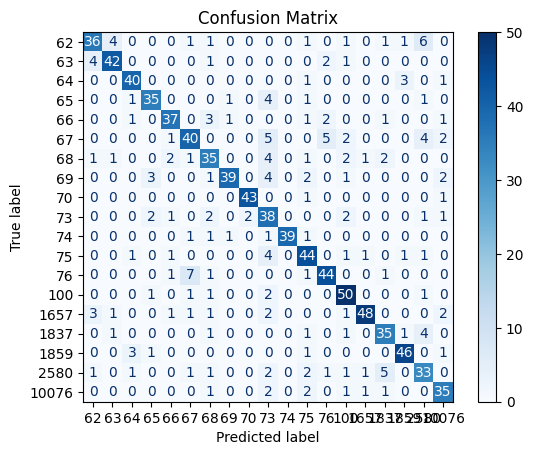

In [8]:
import json
import lightgbm as lgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def load_data(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

def preprocess_data(data):
    text_data = []
    labels = []
    for item in data:
        # 合併文字特徵 (name 和 description)
        name_text = " ".join(item['name_wseg_list'][0])
        description_text = " ".join([" ".join(desc) for desc in item['description_wseg_list']])
        combined_text = f"{name_text} {description_text}"

        text_data.append(combined_text)
        labels.append(item['catid'])

    return text_data, labels

def vectorize_text(train_texts, test_texts):
    vectorizer = TfidfVectorizer(max_features=1000)
    train_vectors = vectorizer.fit_transform(train_texts).toarray()
    test_vectors = vectorizer.transform(test_texts).toarray()
    return train_vectors, test_vectors, vectorizer

def train_lightgbm(train_features, train_labels):
    lgb_train = lgb.Dataset(train_features, train_labels)
    params = {
        'objective': 'multiclass',
        'num_class': len(set(train_labels)),
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'learning_rate': 0.1,
        'num_leaves': 31,
        'verbose': -1
    }
    model = lgb.train(params, lgb_train, num_boost_round=100)
    return model

train_data = load_data('train_data.json')
test_data = load_data('test_data.json')

train_texts, train_labels = preprocess_data(train_data)
test_texts, test_labels = preprocess_data(test_data)

# 使用 LabelEncoder 將類別標籤轉換為數字
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
test_labels = label_encoder.transform(test_labels)

# 向量化文字資料
train_features, test_features, vectorizer = vectorize_text(train_texts, test_texts)

# 訓練模型
model = train_lightgbm(train_features, train_labels)

# 測試模型
predicted_probs = model.predict(test_features)
predicted_labels = predicted_probs.argmax(axis=1)

# 還原類別標籤
predicted_labels = label_encoder.inverse_transform(predicted_labels)
test_labels = label_encoder.inverse_transform(test_labels)

# 評估模型
accuracy = accuracy_score(test_labels, predicted_labels)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print("Classification Report:\n", classification_report(test_labels, predicted_labels))

# 計算並顯示混淆矩陣
conf_matrix = confusion_matrix(test_labels, predicted_labels, labels=label_encoder.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()
